<a href="https://colab.research.google.com/github/arthurflor23/computer-vision/blob/master/HW02/HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GrabCat: Foreground-Background Segmentation via Clustering

## 1 Introduction

In this assignment, you will use clustering algorithms to segment images. You will then use these segmenta- tions to identify foreground and background objects. And finally, you will transfer foreground objects from one image to another.

Your assignment will involve the following subtasks:

* **Clustering algorithms**: Implement K-Means clustering and Hierarchical Agglomerative Clustering.

* **Pixel feature vectors**: Implement a feature vector that combines color and position information and implement feature normalization.

* **Image Segmentation**: Segment several images using a variety of parameters and qualitatively assess your results.

* **GrabCat**: Transfer Segments Between Images: Transfer objects from one image to another.

* **Quantitative Evaluation**: Evaluate segmentation algorithms with a variety of parameter settings by comparing your computed segmentations against a dataset of ground-truth segmentations.

In [0]:
### import dependencies
import matplotlib.pyplot as plt
import numpy as np
import urllib
import cv2


### plot method adaptable to N images
def plot(images, titles):
    size = 10*len(images)
    plt.figure(figsize=(size,size))

    for index, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), index+1)
        plt.imshow(image, cmap="gray")
        plt.title(title + " image")
        plt.grid(False)
        
    plt.show()


### read iamge through url from github
def read_image_url(name, ext="jpg", folder="imgs"):
    ### get the image url from github repository
    url = ("https://github.com/arthurflor23/computer-vision/blob/master/HW02/%s/%s.%s?raw=true" % (folder, name, ext))
    
    ### request to read and decode image to RGB
    with urllib.request.urlopen(url) as url_image:
        image = np.asarray(bytearray(url_image.read()), dtype="uint8")
        image = cv2.cvtColor(cv2.imdecode(image, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    
    return image


### list name from dataset
cat_im = [
    "black_kitten_star",
    "black_kitten",
    "black-white-kittens2",
    "cat_bed",
    "cat_grumpy",
    "cat_march",
    "cat_mouse",
    "cat-jumping-running-grass",
    "cutest-cat-ever-snoopy-sleeping",
    "grey-american-shorthair",
    "grey-cat-grass",
    "kitten9",
    "kitten16",
    "stripey-kitty",
    "the-black-white-kittens",
    "tortoiseshell_shell_cat",
    "young-calico-cat",
]

## 2 Clustering Algorithms

### 2.1 K-Means Clustering

As discussed in class, K-Means is one of the most popular clustering algorithms. We have provided skeleton code for K-Means clustering in the file KMeansClustering.m. 

* Your first task is to finish implementing the K- Means algorithm using the provided file. You can use KMeansClusteringTest.m to test your implementation.

In [0]:
### get kmeans values from image.
### k represents the cluters number to use.
def kmeans(image, k):
    img_f = np.float32(image.reshape((-1, image.shape[2])))
    
    ### define criteria, number of clusters(K) and apply kmeans()
    ### criteria: (type, max_iter, epsilon)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ### output parameters: 
    ###   compactness : It is the sum of squared distance from each point to their corresponding centers.
    ###   labels : This is the label array (same as ‘code’ in previous article) where each element marked ‘0’, ‘1’...
    ###   centers : This is array of centers of clusters.
    compactness, labels, centers = cv2.kmeans(img_f, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

    ### convert back into uint8, and make original image
    centers = np.uint8(centers)
    res = centers[labels.flatten()]
    res = res.reshape((image.shape))
    
    return res, [compactness, labels, centers]


### get the palette of colors from k-means output parametrs
def get_palette(clc):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    num_labels = np.arange(0, len(np.unique(clc[1])) + 1)
    (hist, _) = np.histogram(clc[1], bins=num_labels)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
   
    # initialize the bar chart representing the relative frequency of each of the colors
    height, width = 50, 350
    bar = np.zeros((height, width, 3), dtype="uint8")
    start_x = 0

    # loop over the percentage of each cluster and the color of each cluster
    for (percent, color) in zip(hist, clc[2]):
        # plot the relative percentage of each cluster
        end_x = start_x + (percent * width)
        cv2.rectangle(bar, (int(start_x), 0), (int(end_x), height), color.astype("uint8").tolist(), -1)
        start_x = end_x

    return bar

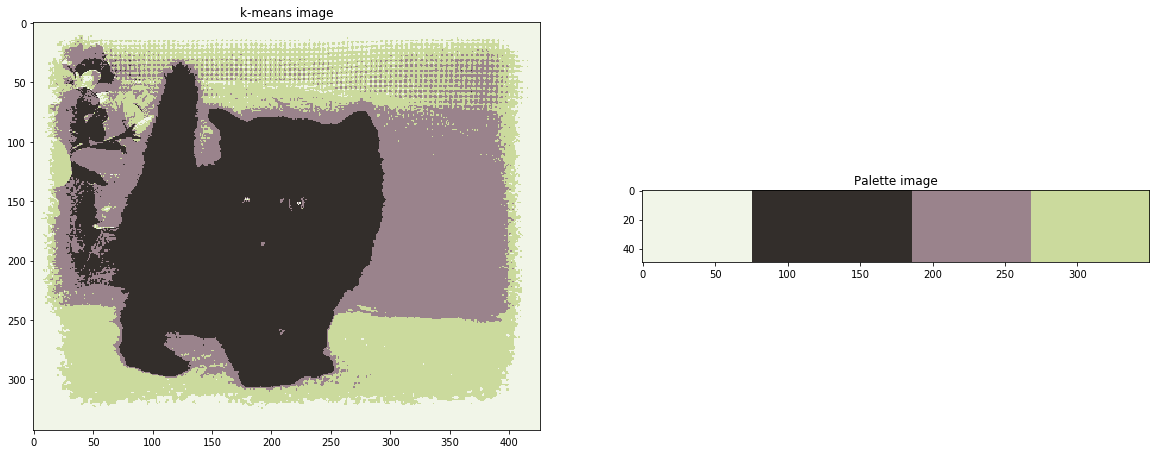

In [0]:
image = read_image_url(cat_im[1])

### set kmeans and get palette from image
kmeans_im, clc = kmeans(image, 4)
color_palette = get_palette(clc)

### plot images with k-means clusters and your palette colors
plot([kmeans_im, color_palette], ["k-means", "Palette"])

### 2.2 Hierarchical Agglomerative Clustering

Another simple clustering algorithm is Hierarchical Agglomerative Clustering, which is sometimes abbreviated as HAC. In this algorithm, each point is initially assigned to its own cluster. Then cluster pairs are merged until we are left with the desired number of predetermined clusters. We have provided skeleton code for hierarchical agglomorative clustring in the file HAClustering.m. 

* Please finish the implementation in this file. You can use HAClusteringTest.m to test your implementation.

In [0]:
### import dependencies
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.image import grid_to_graph
from scipy.cluster.hierarchy import dendrogram, linkage


### get agglomerative clustering values from image
def hac(image, k):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # resize it to 20% of the original size to speed up the processing
    # applying a Gaussian filter for smoothing prior to down-scaling reduces aliasing artifacts.
    nH, nW = np.multiply(image.shape, 0.2)[:2].astype(int)
    blur = cv2.GaussianBlur(gray, (5,5), 2)
    rescaled = cv2.resize(blur, (nW,nH))
    
    ### define the structure A of the data. Pixels connected to their neighbors.
    connectivity = grid_to_graph(*rescaled.shape)
    
    ### compute structured hierarchical clustering
    X = np.reshape(rescaled, (-1,1))
    ward = AgglomerativeClustering(n_clusters=k, linkage="ward", connectivity=connectivity)
    ward.fit(X)
    labels = np.array(np.reshape(ward.labels_, rescaled.shape), dtype='uint8')

    ### rescale to original size
    labels = cv2.resize(labels, gray.shape[::-1])

    return labels


### plot contours from clusters labels and get separate clusters in images (0-255)
def plot_clusters(image, labels):
    im = image.copy()
    contour = []

    ### loop of the number clusters
    for l in range(np.max(labels)+1):
        ### start initial matrix with zeros
        initial = np.zeros(im.shape[:2], dtype=np.uint8)
        ### change 0 values to 255 where labels value is equal l
        initial = np.where(labels==l, 255, initial)
        
        ### add image of the current cluster to the list
        ### and get the canny edges
        c = cv2.Canny(initial, 100, 200)
                    
        ### dilate edges found (a bit)
        kernel = np.ones((3,3), np.uint8)
        c = cv2.dilate(c, kernel, 1)
        
        _, contours, heirarchy = cv2.findContours(c, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = sorted(contours, key=cv2.contourArea, reverse=True)

        ### draw found contour
        con = np.zeros(image.shape, np.uint8)
        cv2.drawContours(con, cnts, 0, 255, 3)
        contour.append(con)
        
        c = cv2.cvtColor(c, cv2.COLOR_GRAY2RGB)

        ### color the current contour with random color
        rgb = list(np.random.choice(range(256), size=3))
        im = np.where(c==[255,255,255], rgb, im)

    return im, contour

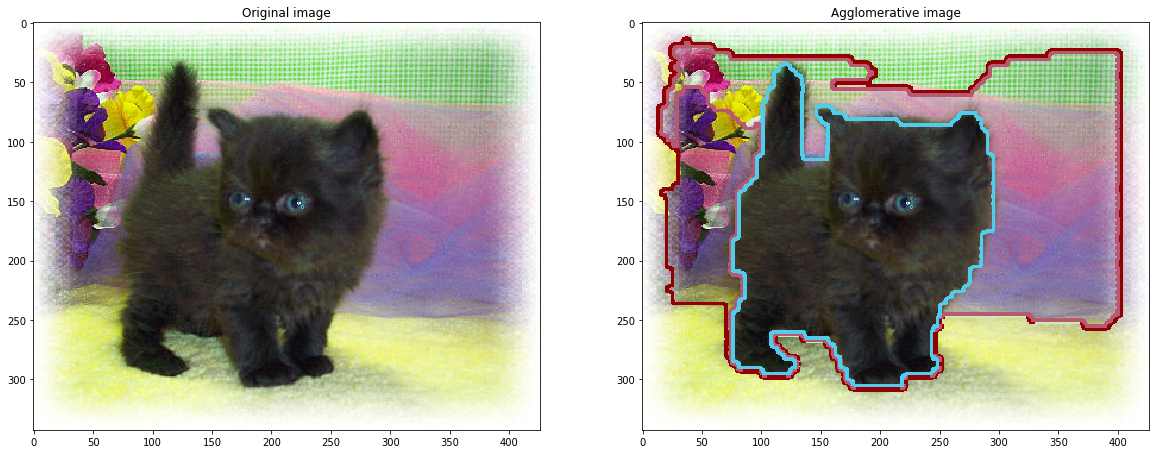

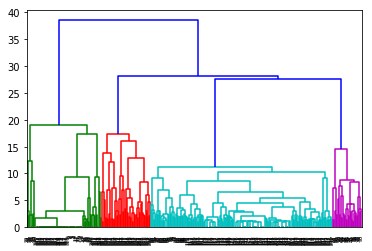

In [0]:
image = read_image_url(cat_im[1])

### call hac method and define 4 clusters
### and call plot_clusters method
labels = hac(image, 4)
agglomerative_im, contours = plot_clusters(image, labels)

### plot original image, agglomerative image (with contours) 
### and hierarchical plot with dendrogram method
plot([image, agglomerative_im], ["Original", "Agglomerative"])
plot_dendrogram = dendrogram(linkage(labels, 'centroid'))

## 3 Pixel Feature Vectors

### 3.1 Color Features

One of the simplest possible feature vectors for a pixel is simply the vector of colors for that pixel. This method has been implemented for you in the file ComputeColorFeatures.m.

In [0]:
image = read_image_url(cat_im[11])

### get color_features (only copying the original image rgb values)
c_features = image.copy()

### print the shape and vectors with color features (r,g,b)
print("Shape (vectors_y, vectors_x, features):", c_features.shape)
print("\nFeatures (r,g,b):\n\n", c_features)

Shape (vectors_y, vectors_x, features): (480, 640, 3)

Features (r,g,b):

 [[[164 159 155]
  [166 161 157]
  [171 163 160]
  ...
  [159 148 142]
  [175 164 158]
  [159 148 142]]

 [[164 159 155]
  [166 161 157]
  [171 163 160]
  ...
  [171 160 154]
  [172 161 155]
  [172 161 155]]

 [[164 159 155]
  [167 162 158]
  [170 162 159]
  ...
  [166 155 151]
  [163 152 148]
  [172 161 157]]

 ...

 [[234 231 224]
  [238 235 228]
  [235 232 225]
  ...
  [200 191 194]
  [197 188 191]
  [204 195 198]]

 [[232 229 222]
  [238 235 228]
  [235 232 225]
  ...
  [210 201 204]
  [193 184 187]
  [199 190 193]]

 [[231 228 221]
  [238 235 228]
  [234 231 224]
  ...
  [201 192 195]
  [192 183 186]
  [192 183 186]]]


### 3.2 Color and Position Features

Another simple feature vector for a pixel is to concatenate its color and its position within the image. In other words, for a pixel of color (r, g, b) located at position (x, y) in the image, its feature vector would be (r, g, b, x, y). 

* Implement this method of computing feature vectors in the file ComputePositionColorFeatures.m. You can test your implementation by running ComputePositionColorFeaturesTest.m.

In [0]:
### method definition with loop concatenating the rgb vector of the image with the position of the pixel
def color_position_features(image):
    h, w, _ = image.shape
    f = np.array([np.concatenate((image[y,x], [y, x]), axis=0) for x in range(w) for y in range(h)])
    return np.reshape(f, (h, w, len(f[0])))


image = read_image_url(cat_im[11])

### call method color_position_features
cp_features = color_position_features(image)

### print the shape and vectors with color and position features (r,g,b,x,y)
print("Shape (vectors_y, vectors_x, features):", cp_features.shape)
print("\nFeatures (r,g,b,x,y):\n\n", cp_features)

Shape (vectors_y, vectors_x, features): (480, 640, 5)

Features (r,g,b,x,y):

 [[[164 159 155   0   0]
  [164 159 155   1   0]
  [164 159 155   2   0]
  ...
  [183 173 172 157   1]
  [181 171 169 158   1]
  [185 175 173 159   1]]

 [[185 175 174 160   1]
  [184 176 174 161   1]
  [185 177 175 162   1]
  ...
  [237 236 232 317   2]
  [237 236 232 318   2]
  [236 235 231 319   2]]

 [[237 236 232 320   2]
  [235 234 230 321   2]
  [239 238 234 322   2]
  ...
  [235 232 225 477   3]
  [233 230 223 478   3]
  [232 229 222 479   3]]

 ...

 [[148 137 131   0 636]
  [179 168 162   1 636]
  [173 162 158   2 636]
  ...
  [187 176 174 157 637]
  [183 172 170 158 637]
  [182 171 169 159 637]]

 [[182 171 169 160 637]
  [179 168 166 161 637]
  [183 172 170 162 637]
  ...
  [241 236 230 317 638]
  [240 235 229 318 638]
  [241 236 230 319 638]]

 [[237 232 226 320 638]
  [239 234 228 321 638]
  [239 234 228 322 638]
  ...
  [204 195 198 477 639]
  [199 190 193 478 639]
  [192 183 186 479 639]]]


### 3.3 Feature Normalization

One way to correct for uneven scaling between different features is to apply some sort of normalization to the feature vector. One of the simplest types of normalization is to force each feature to have zero mean and unit variance.

Suppose that we have a set of feature vectors f<sub>1</sub>, . . . , f<sub>n</sub> where each f<sub>i</sub> E R<sup>m</sup> is the feature vector for a single pixel, and f<sub>ij</sub> is the value of the jth feature for the ith pixel. We can then compute the mean μ<sub>j</sub> and variance σ<sub>j</sub><sup>2</sup> of each feature as follows

<img src="https://github.com/arthurflor23/computer-vision/blob/master/HW02/helpers/01.png?raw=true" width="450" height="75"/>

To force each feature to have zero mean and unit variance, we replace our feature vectors f<sub>1</sub>, . . . , f<sub>n</sub> with a modified set of feature vectors f<sub>1</sub> , . . . , f<sub>n</sub> where

<img src="https://github.com/arthurflor23/computer-vision/blob/master/HW02/helpers/02.png?raw=true" width="150"/>

* Implement this method of feature vector normalization in the file NormalizeFeatures.m. You can test your implementation by running NormalizeFeaturesTest.m.

In [0]:
### method definition of the feature normalization process
def feature_normalization(image):

    ### method to perform calcule
    def norm(pixel):
        average = np.average(pixel)
        std = np.std(pixel)
        
        ### if standard deviation higher 0, then perform the normalization equation
        if std > 0:
            return [(pixel[j]-average)/std for j in range(len(pixel))]        
        return [0. for j in range(len(pixel))]

    return np.apply_along_axis(norm, 2, image)


image = read_image_url(cat_im[11])

### call method feature_normalization
norm_features = feature_normalization(image)

### print the shape and vectors with the features normalized
print("Shape (vectors_y, vectors_x, features):", norm_features.shape)
print("\nFeatures normalized:\n\n", norm_features)

Shape (vectors_y, vectors_x, features): (480, 640, 3)

Features normalized:

 [[[ 1.26750044 -0.09053575 -1.1769647 ]
  [ 1.26750044 -0.09053575 -1.1769647 ]
  [ 1.3641205  -0.35897908 -1.00514142]
  ...
  [ 1.32583843 -0.23675686 -1.08908156]
  [ 1.32583843 -0.23675686 -1.08908156]
  [ 1.32583843 -0.23675686 -1.08908156]]

 [[ 1.26750044 -0.09053575 -1.1769647 ]
  [ 1.26750044 -0.09053575 -1.1769647 ]
  [ 1.3641205  -0.35897908 -1.00514142]
  ...
  [ 1.32583843 -0.23675686 -1.08908156]
  [ 1.32583843 -0.23675686 -1.08908156]
  [ 1.32583843 -0.23675686 -1.08908156]]

 [[ 1.26750044 -0.09053575 -1.1769647 ]
  [ 1.26750044 -0.09053575 -1.1769647 ]
  [ 1.3641205  -0.35897908 -1.00514142]
  ...
  [ 1.36652966 -0.36791183 -0.99861783]
  [ 1.36652966 -0.36791183 -0.99861783]
  [ 1.36652966 -0.36791183 -0.99861783]]

 ...

 [[ 1.03422447  0.31822291 -1.35244738]
  [ 1.03422447  0.31822291 -1.35244738]
  [ 1.03422447  0.31822291 -1.35244738]
  ...
  [ 1.33630621 -1.06904497 -0.26726124]
  [ 1.

### Get Creative!

For this programming assignment we have asked you to implement a very simple feature transform for each pixel. While it is not required, you should feel free to experiment with other feature transforms. Could your final segmentations be improved by adding gradients, edges, SIFT descriptors, or other information to your feature vectors? Could a different type of normalization give better results?

* In your writeup you should describe all methods of computing feature vectors that you use in your project. For each method of computing feature vectors, explain why you expect that this feature vector will or will not produce a good segmentation for an image.

In [0]:
### method definition of the custom features vector.
###
### the method mix the results of the above methods and make the normalization:
###
### join [color + position] with [features normalizated of the image], then:
###    for each vector = [r, g, b, y, x, r_norm, g_norm, b_norm]
###
### after that, all new vectors (with the new results) are normalized
###
def custom_features(image):
    cp_features = color_position_features(image)
    norm_features = feature_normalization(image)
    custom = np.concatenate((cp_features, norm_features), axis=2)

    return feature_normalization(custom)


image = read_image_url(cat_im[11])

### call method custom_features
custom = custom_features(image)

### print the shape and vectors with custom features normalized
print("Shape (vectors_y, vectors_x, features):", custom.shape)
print("\nCustom features normalized:\n\n", custom)

Shape (vectors_y, vectors_x, features): (480, 640, 8)

Custom features normalized:

 [[[ 1.35087346  1.28608337  1.23425129 ... -0.75781733 -0.77541479
   -0.78949276]
  [ 1.35093654  1.28606563  1.23416891 ... -0.76038427 -0.77800368
   -0.7920992 ]
  [ 1.35097694  1.28602612  1.23406547 ... -0.76168962 -0.78407297
   -0.79246672]
  ...
  [ 1.13405295  1.01744082  1.00577961 ... -0.98448812 -1.00270988
   -1.01264902]
  [ 1.1300865   1.01236916  0.98882569 ... -0.98499    -1.00338446
   -1.0134178 ]
  [ 1.13562558  1.02018715  0.99709946 ... -0.98468015 -1.00271851
   -1.01255761]]

 [[ 1.12974201  1.01460907  1.00309577 ... -0.98562435 -1.00125982
   -1.01376819]
  [ 1.11559676  1.02358878  1.00058679 ... -0.98600927 -1.00162804
   -1.01412306]
  [ 1.11495033  1.02346723  1.00059645 ... -0.9849972  -1.00470152
   -1.01209063]
  ...
  [ 0.83873144  0.83103666  0.80025752 ... -0.97473029 -0.98675413
   -0.99331258]
  [ 0.83659745  0.82891343  0.79817736 ... -0.97432703 -0.98633404
   -

## 4 Image Segmentation

In [0]:
### help methods for segmentation questions

### get contour with the major area
def get_contour(image):
    ### filter to minimize noises
    image = cv2.GaussianBlur(image, (3, 3), 1)
    
    ### threshold otsu
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    ### find the countours and sort with the area key
    _, contours, heirarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=cv2.contourArea, reverse=True)
    
    ### draw found contour
    contour = np.zeros(image.shape, np.uint8)
    cv2.drawContours(contour, cnts, 0, 255, 3)
    
    return contour


### filling holes at image
def filling_holes(image):
    ### threshold otsu to prevent
    _, th_im = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # copy the thresholded image
    floodfill_im = th_im.copy()

    # mask used to flood filling
    # notice the size needs to be 2 pixels than the image
    h, w = image.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    
    # floodfill method from point (0, 0)
    cv2.floodFill(floodfill_im, mask, (h//3, w//3), 255);

    # combine the two images to get the foreground.
    im = (th_im | cv2.bitwise_not(floodfill_im))

    if im[0,0] > 0:
        im = cv2.bitwise_not(im)
            
    im[im>0] = 1
    return im

In your writeup you should include visualizations of at least 4 different segmentations. At least 2 of these segmentations should be successful, and at least 2 of these segmentations should be unsuccessful. Each of your examples should use different parameters for segmentation, and the parameters for each of your examples should be different.

You should also answer the following questions in your writeup (a few sentences for each question is sufficient):

* What effect do each of the segmentation parameters (feature transform, feature normalization, number of clusters, clustering method, resize) have on the quality of the final segmentation?

* How do each of these parameters affect the speed of computing a segmentation?

* How do the properties of an image affect the difficulty of computing a good segmentation for that image?

Successful segmentation with k-means method:


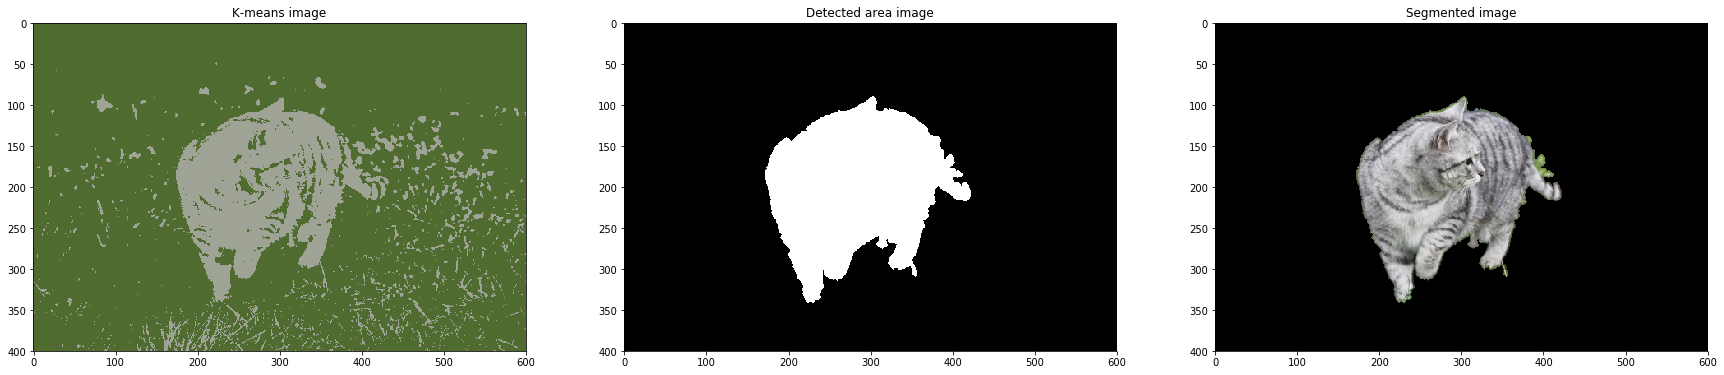



Unsuccessful segmentation with k-means method:


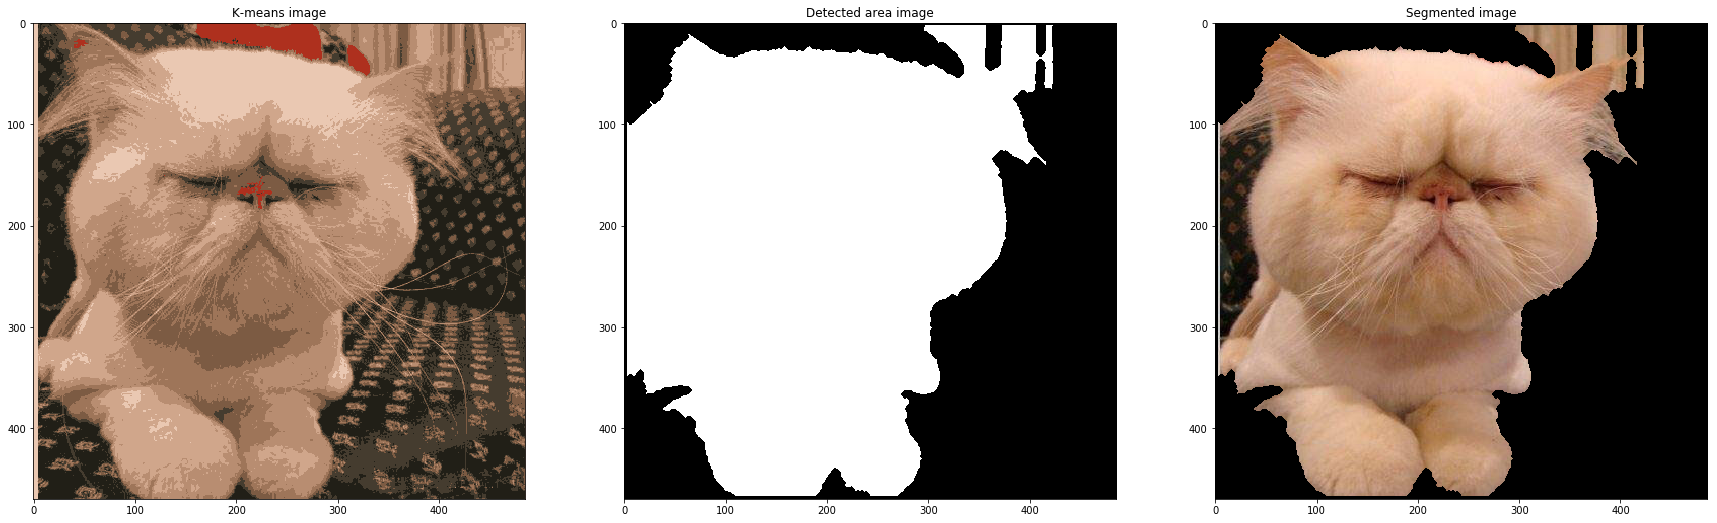

In [0]:
### segmentation with k-means (rgb)
###########################################

### image segmentation through k-means 
def k_means_segmentation(image, k):
    kmeans_im, _ = kmeans(image, k)
            
    ### get the contour and filling the area
    gray_im = cv2.cvtColor(kmeans_im, cv2.COLOR_RGB2GRAY)
    _, gray_im = cv2.threshold(gray_im, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    if gray_im[10,10]>0:
        gray_im = cv2.bitwise_not(gray_im)
        
    contour_im = get_contour(gray_im)
    fill_im = filling_holes(contour_im)
        
    ### segment the original image with the found area
    rgb_fill_im = cv2.cvtColor(fill_im, cv2.COLOR_GRAY2RGB)
    segment_im = np.multiply(image, rgb_fill_im)
    
    return kmeans_im, fill_im*255, segment_im
    

## found contour and segmentation (!! Successful !!)
kmeans_im, fill_im, segment_im = k_means_segmentation(read_image_url(cat_im[10]), 2)

print("Successful segmentation with k-means method:")
plot([kmeans_im, fill_im, segment_im], ["K-means", "Detected area", "Segmented"])


### found contour and segmentation (!! Unsuccessful !!)
kmeans_im, fill_im, segment_im = k_means_segmentation(read_image_url(cat_im[4]), 8)

print("\n\nUnsuccessful segmentation with k-means method:")
plot([kmeans_im, fill_im, segment_im], ["K-means", "Detected area", "Segmented"])


### objects with colors similar to the background are not segments correctly. 
### the possibility of minimizing the error is through morphological parameters in this case (which is not ideal).

Successful segmentation with hierarchical agglomerative method:


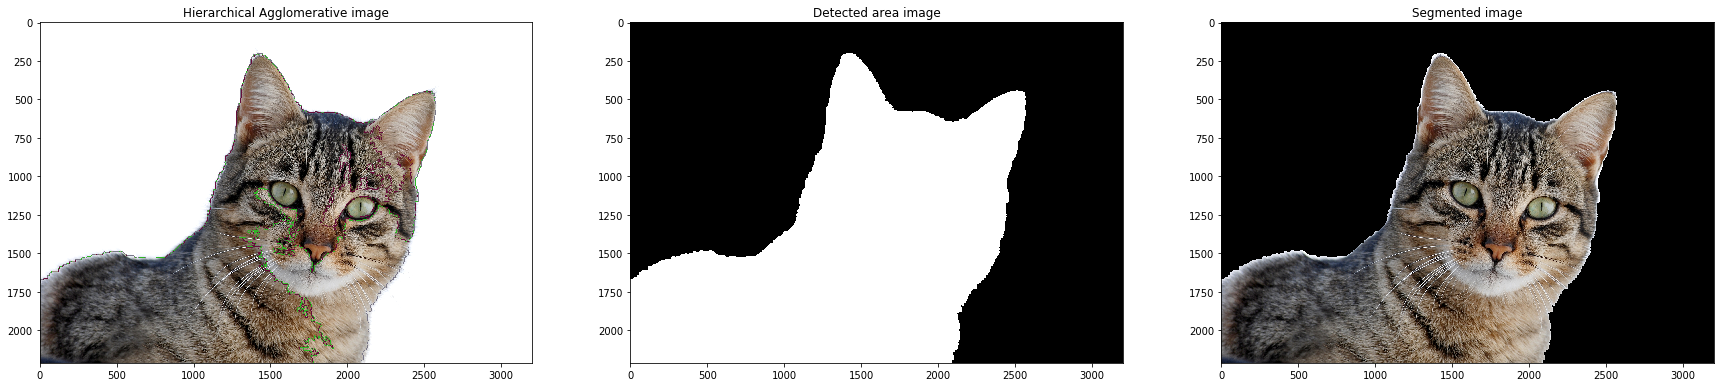



Unsuccessful segmentation with hierarchical agglomerative method:


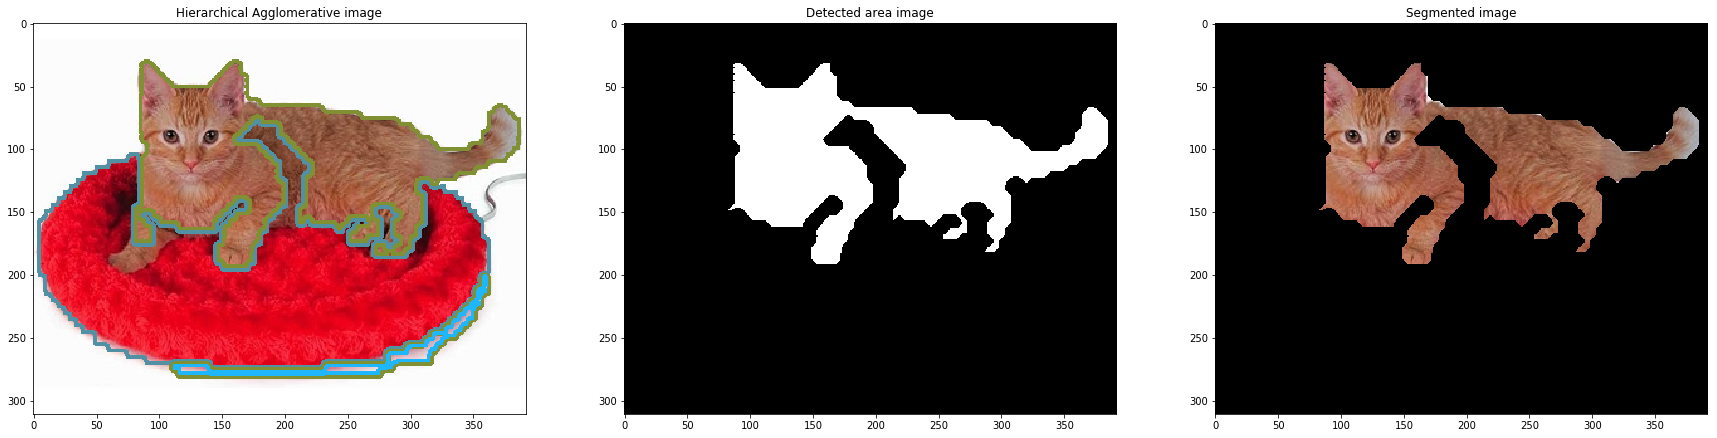

In [0]:
### segmentation with hierarchical agglomerative (rgb)
###########################################

### image segmentation through hierarchical agglomerative 
def agglomerative_segmentation(image, k):
    labels = hac(image, k)
    agglomerative_im, contours_im = plot_clusters(image, labels)
    
    ### filling the holes with the gray image of contours
    c = 2 if len(contours_im) > 2 else 1
    contour_im = cv2.cvtColor(contours_im[c], cv2.COLOR_RGB2GRAY)
    
    fill_im = filling_holes(contour_im)

    ### segment the original image with the found area
    rgb_fill_im = cv2.cvtColor(fill_im, cv2.COLOR_GRAY2RGB)
    segment_im = np.multiply(image, rgb_fill_im)
    
    return agglomerative_im, fill_im*255, segment_im
    

### found contour and segmentation (!! Successful !!)
agglo_im, fill_im, segment_im = agglomerative_segmentation(read_image_url(cat_im[5]), 4)

print("Successful segmentation with hierarchical agglomerative method:")
plot([agglo_im, fill_im, segment_im], ["Hierarchical Agglomerative", "Detected area", "Segmented"])


### found contour and segmentation (!! Unsuccessful !!)
agglo_im, fill_im, segment_im = agglomerative_segmentation(read_image_url(cat_im[3]), 4)

print("\n\nUnsuccessful segmentation with hierarchical agglomerative method:")
plot([agglo_im, fill_im, segment_im], ["Hierarchical Agglomerative", "Detected area", "Segmented"])


### the hierarchical agglomerative method works a better than k-means when colors are similar,
### but is still strongly dependent on morphological parameters in this case (which is not ideal again).

Successful segmentation with Otsu's thresholding:


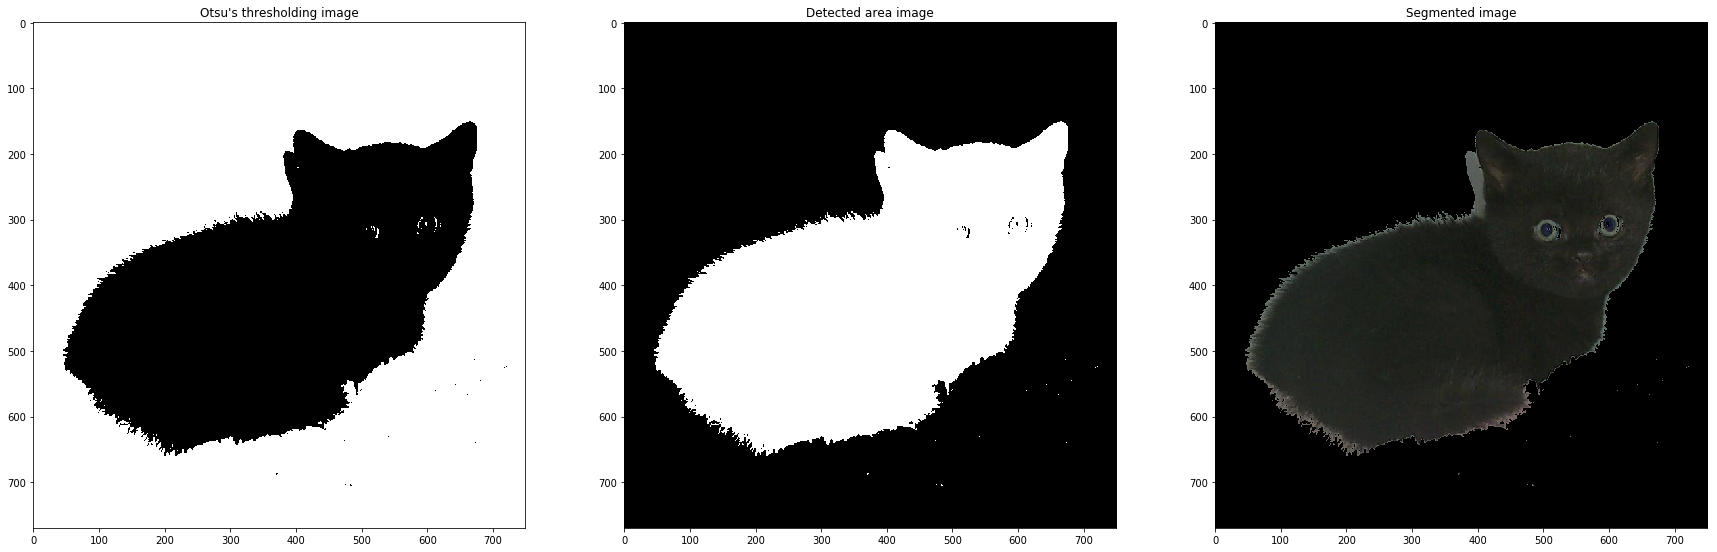



Unsuccessful segmentation with Otsu's thresholding:


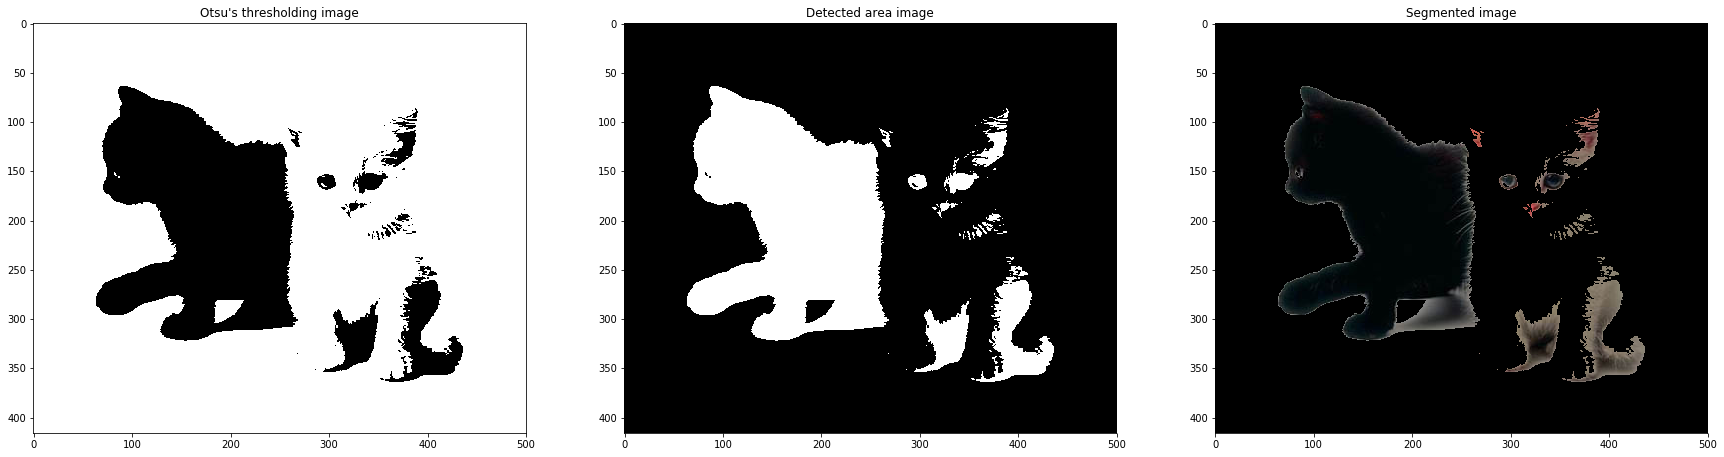

In [0]:
### segmentation with Otsu's thresholding
###########################################

### image segmentation through binarization
def threshold_segmentation(image, k=None):
    gray_im = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    ### thresholding image with otsu method 
    _, threshold_im = cv2.threshold(gray_im, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    if gray_im[10,10]>0:
        fill_im = cv2.bitwise_not(threshold_im)
    fill_im *= 255
    
    ### segment the original image with the found area
    rgb_fill_im = cv2.cvtColor(fill_im, cv2.COLOR_GRAY2RGB)
    segment_im = np.multiply(image, rgb_fill_im)
    
    return threshold_im, fill_im, segment_im


### threshold and segmentation (!! Successful !!)
thres_im, fill_im, segment_im = threshold_segmentation(read_image_url(cat_im[0]))

print("Successful segmentation with Otsu's thresholding:")
plot([thres_im, fill_im, segment_im], ["Otsu's thresholding", "Detected area", "Segmented"])


### threshold and segmentation (!! Unsuccessful !!)
thres_im, fill_im, segment_im = threshold_segmentation(read_image_url(cat_im[2]))

print("\n\nUnsuccessful segmentation with Otsu's thresholding:")
plot([thres_im, fill_im, segment_im], ["Otsu's thresholding", "Detected area", "Segmented"])


### the segmentation through binarization is good for images that have the study object highlighted 
### in black or white (inverted mode method). However, is quite flawed in most scenarios.

Successful segmentation with features normalization:


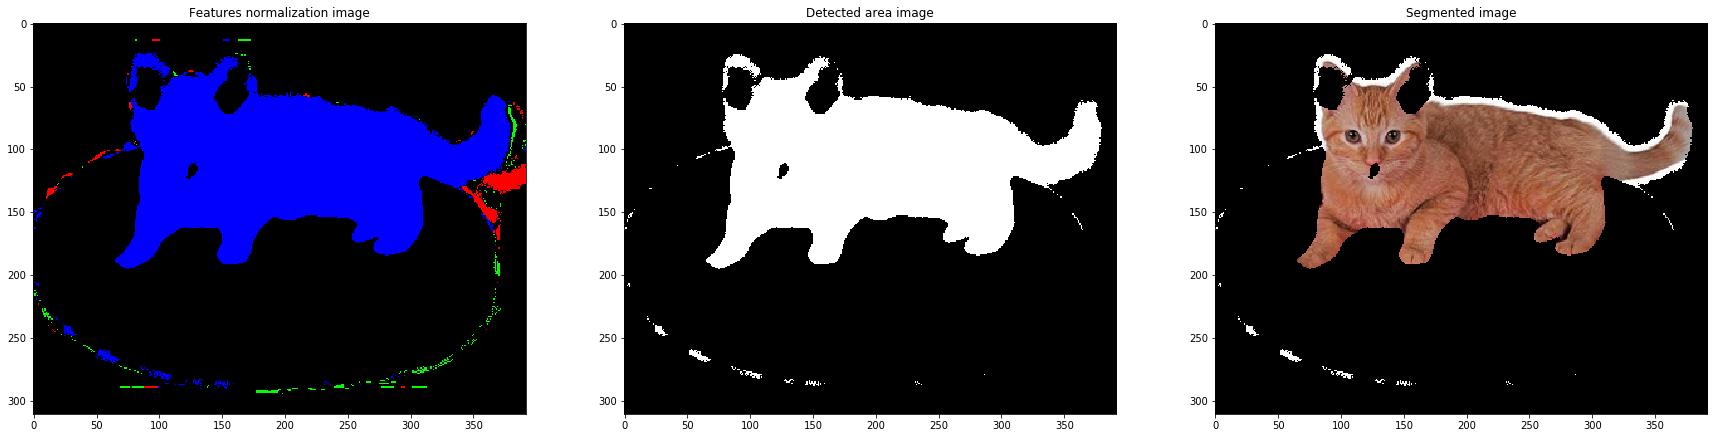



Unsuccessful segmentation with features normalization:


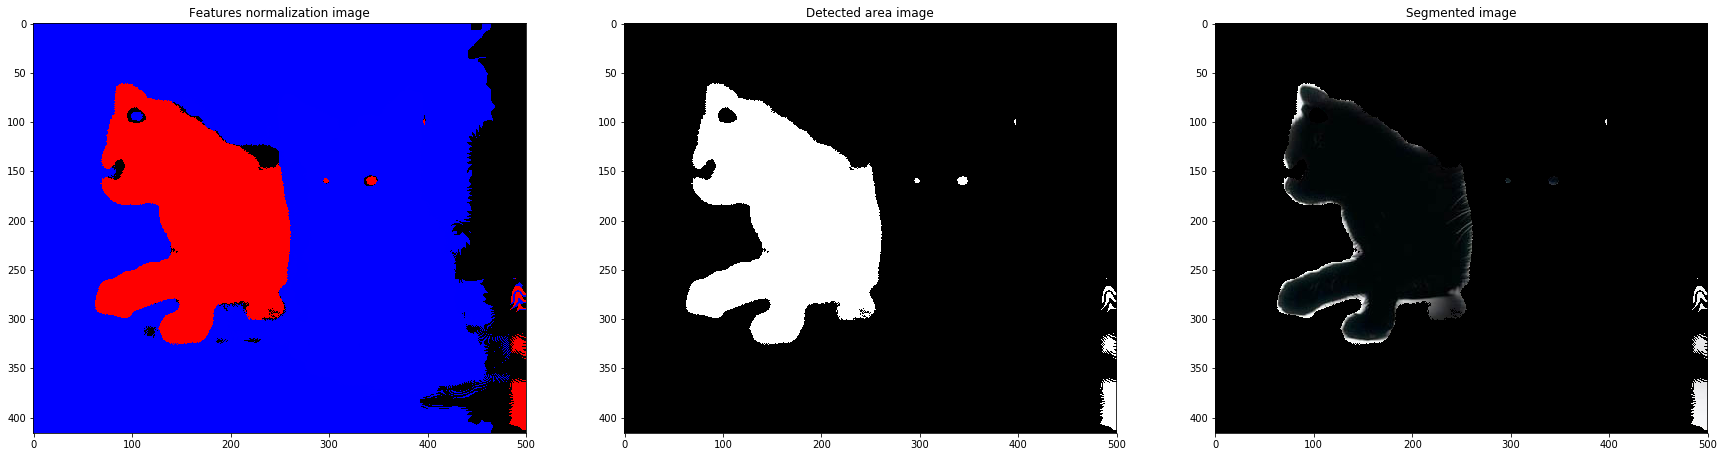

In [0]:
### segmentation with the custom features
###########################################

### image segmentation through custom features
def features_segmentation(image, k):
    blur_im = cv2.GaussianBlur(image, (11,11), 5)
    
    ### feature extraction
    features = feature_normalization(blur_im)
    kmeans_im, clc = kmeans(features, k)
    
    ### get groups to segment
    groups = np.reshape(clc[1], image.shape[:2])
    list_groups = []
    
    for x in range(k):
        t = np.zeros(image.shape[:2])
        t[groups==x] = 255
        list_groups.append(t)

    ### sort the k-means groups by sum (define an organization, since k-means is random)
    list_groups = sorted(list_groups, key=np.sum, reverse=True)    
    
    c = 2 if len(list_groups) > 2 else 1
    fill_im = np.uint8(list_groups[c])
    fill_im[fill_im>0] = 1
    
    ### segment from original image
    rgb_fill_im = cv2.cvtColor(fill_im, cv2.COLOR_GRAY2RGB)
    segment_im = np.multiply(image, rgb_fill_im)
        
    return kmeans_im, fill_im, segment_im


### threshold and segmentation (!! Successful !!)
features_im, fill_im, segment_im = features_segmentation(read_image_url(cat_im[3]), 8)

print("Successful segmentation with features normalization:")
plot([features_im, fill_im, segment_im], ["Features normalization", "Detected area", "Segmented"])


### threshold and segmentation (!! Unsuccessful !!)
features_im, fill_im, segment_im = features_segmentation(read_image_url(cat_im[2]), 4)

print("\n\nUnsuccessful segmentation with features normalization:")
plot([features_im, fill_im, segment_im], ["Features normalization", "Detected area", "Segmented"])


### the segmentation with features normalization was better than hierarchical agglomerative in the first image,
### but made the same mistake as the otsu method.

## 5 GrabCat: Transfer Segments between Images

Include at least 2 examples of composite images produced by transferring segments from one image to another. For each composite image explain how you produced it (i.e. describe what the input images were and what segmentation parameters were used).

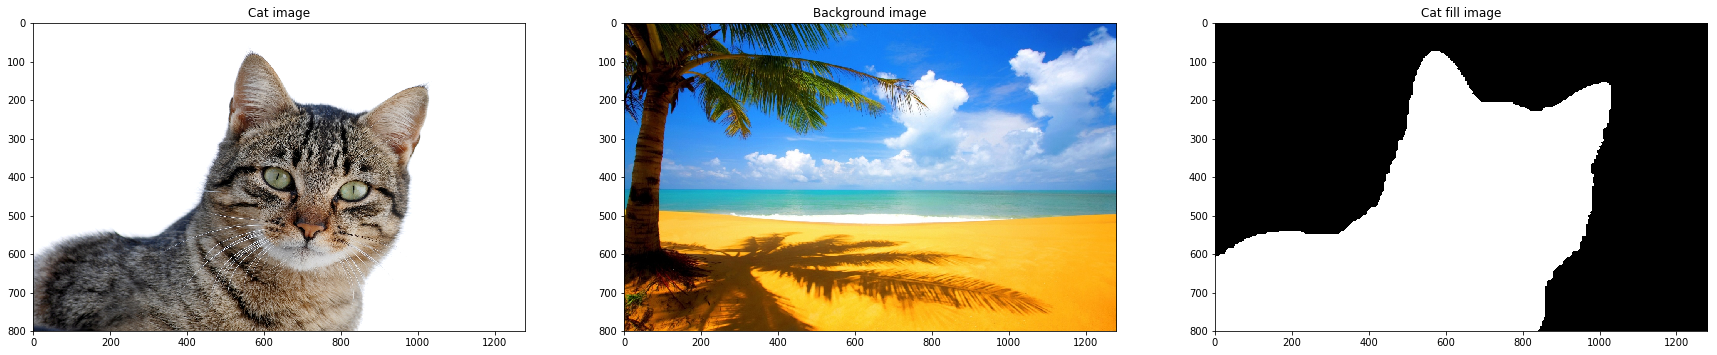

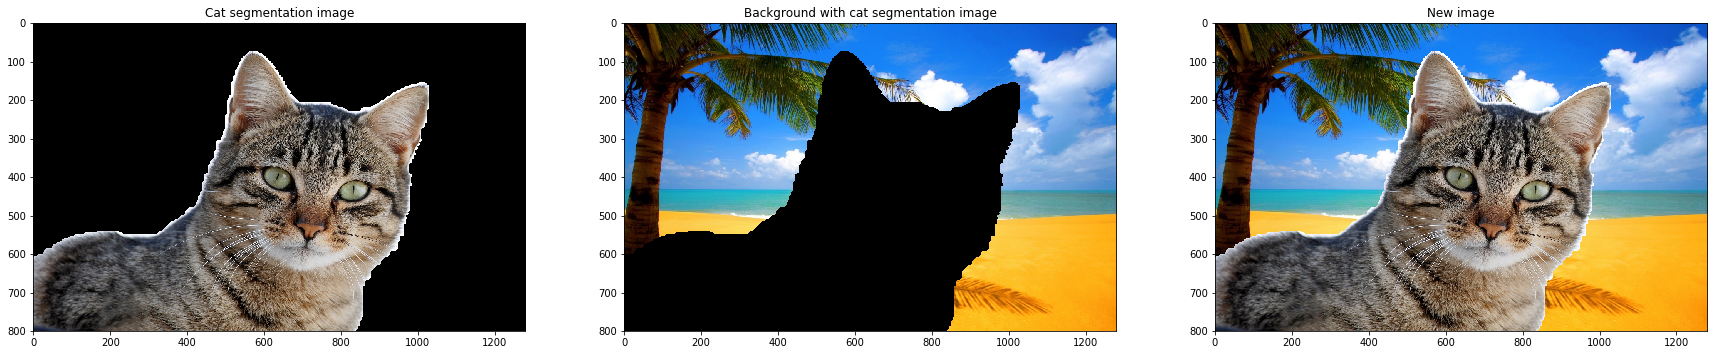

In [0]:
### method to merge images with label/fill image as parameter (black and white)
def merge(cat, background, fill):
    fill = cv2.cvtColor(fill, cv2.COLOR_GRAY2RGB)

    cat = np.where(fill>0, cat, 0)
    background = np.where(fill==0, background, 0)
        
    return cat, background, np.add(cat, background)
    

### get the cat and background image
cat = read_image_url(cat_im[5])
background = read_image_url("beach", folder="imgs/backgrounds")

### resize cat to the background
cat = cv2.resize(cat, background.shape[1::-1])

### get the label for merge
_, fill_im, _ = agglomerative_segmentation(cat, 4)

### merge images
cat_seg, background_seg, cat_background = merge(cat, background, fill_im)


### plot cat              |                    background                    | cat fill
### plot cat segmentation |         background with cat segmentation         | cat on background
plot([cat, background, fill_im], ["Cat", "Background", "Cat fill"])
plot([cat_seg, background_seg, cat_background], ["Cat segmentation", "Background with cat segmentation", "New"])

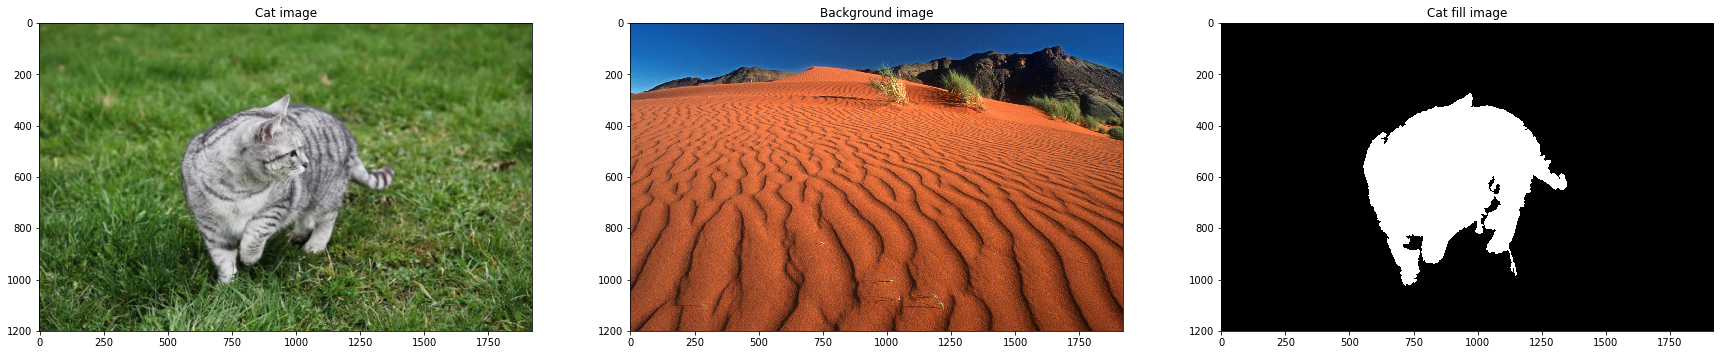

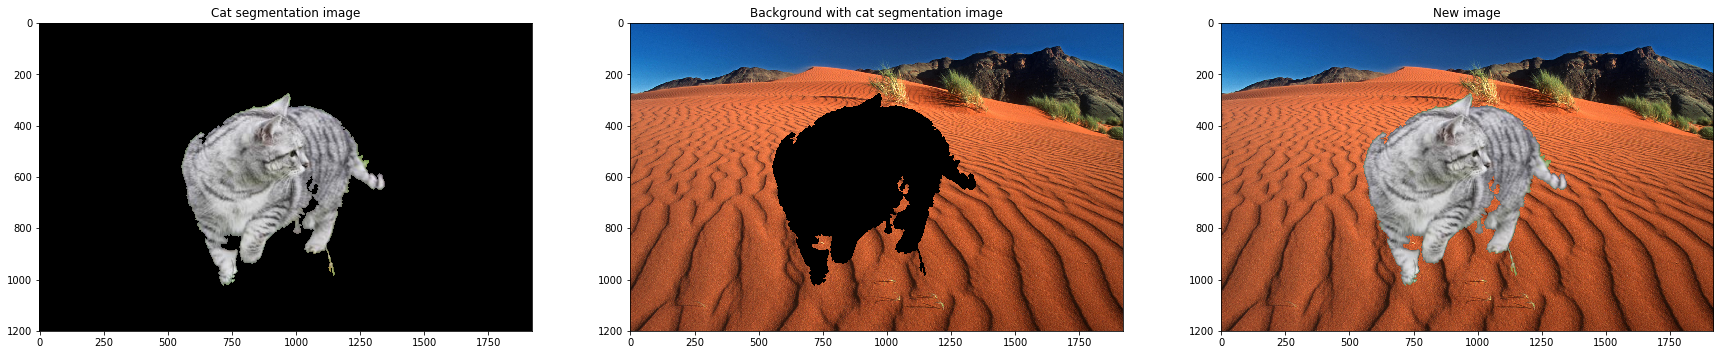

In [0]:
### get the cat and background image
cat = read_image_url(cat_im[10])
background = read_image_url("desert", folder="imgs/backgrounds")

### resize cat to the background
cat = cv2.resize(cat, background.shape[1::-1])

### get the label for merge
_, fill_im, _ = k_means_segmentation(cat, 2)

### merge images
cat_seg, background_seg, cat_background = merge(cat, background, fill_im)


### plot cat              |                    background                    | cat fill
### plot cat segmentation |         background with cat segmentation         | cat on background
plot([cat, background, fill_im], ["Cat", "Background", "Cat fill"])
plot([cat_seg, background_seg, cat_background], ["Cat segmentation", "Background with cat segmentation", "New"])

## 6 Quantitative Evaluation

Include a detailed evaluation of the effect of varying segmentation parameters (feature transform, feature normalization, clustering method, number of clusters, resize) on the mean accuracy of foreground-background segmentations on the provided dataset. You should test a minimum of 10 combinations of parameters. To present your results, you might consider making a table similar to figure bellow.

<img src="https://github.com/arthurflor23/computer-vision/blob/master/HW02/helpers/03.png?raw=true" width="650"/>

You should expand upon the qualitative assessment of Section 4 and try to answer the following question:

* Based on your quantitative experiments, how do each of the segmentation parameters affect the quality of the final foreground-background segmentation?

* Are some images simply more difficult to segment correctly than others? If so, what are the qualities of these images that cause the segmentation algorithms to perform poorly?

* Also feel free to point out or discuss any other interesting observations that you made.

You may combine your discussion in this section with your discussion from Section 4 if you like. However, your grade for both sections will depend on the thoroughness and correctness of your discussion. Just as a point of reference, we anticipate that none of the questions above can be answered in a single sentence; you should back up all answers with either experimental data, or a convincing argument. Overall for this assignment, we care more about your explanation and discussion than about your actual code or results (although those are important too!).


In [0]:
### calculate total accuracy of the segments (function parameter) with the ground truth
def total_accuracy(function, cat_im, k=0):    
    accuracy = 0
    
    ### loop in cat images list (17 images)
    for image in cat_im:
        ### get the ground truth image
        gt = read_image_url(image, "png", "gt")
        gt = cv2.cvtColor(gt, cv2.COLOR_RGB2GRAY)

        ### get segmented image (function parameter to determine the segment method)
        _, fill_im, _ = function(read_image_url(image), k)

        ### images merge. the 100% accuracy has the result all black image (no white pixels)
        sub = np.abs(np.subtract(fill_im, gt))

        ### get the white pixels (no zeros) remaining
        h, w = sub.shape
        accuracy += 1 - (np.count_nonzero(sub) / (h*w))
    
    ### return the average accuracy
    return accuracy/len(cat_im)

In [0]:
### get the accuracy from dataset: k-means with 2 clusters per image
kmeans_acc = total_accuracy(k_means_segmentation, cat_im, k=2)
print ("Features: RGB\t|\tNorm: No\t|\tMethod: K-Means\t\t|\tClusters: 2\t|\tResize: None\t|\tAccuracy:", kmeans_acc)

### get the accuracy from dataset: k-means with 4 clusters per image
kmeans_acc = total_accuracy(k_means_segmentation, cat_im, k=4)
print ("Features: RGB\t|\tNorm: No\t|\tMethod: K-Means\t\t|\tClusters: 4\t|\tResize: None\t|\tAccuracy:", kmeans_acc)

### get the accuracy from dataset: k-means with 8 clusters per image
kmeans_acc = total_accuracy(k_means_segmentation, cat_im, k=8)
print ("Features: RGB\t|\tNorm: No\t|\tMethod: K-Means\t\t|\tClusters: 8\t|\tResize: None\t|\tAccuracy:", kmeans_acc)

Features: RGB	|	Norm: No	|	Method: K-Means		|	Clusters: 2	|	Resize: None	|	Accuracy: 0.7536082862458737
Features: RGB	|	Norm: No	|	Method: K-Means		|	Clusters: 4	|	Resize: None	|	Accuracy: 0.7208161259607397
Features: RGB	|	Norm: No	|	Method: K-Means		|	Clusters: 8	|	Resize: None	|	Accuracy: 0.7365522003133949


In [0]:
### get the accuracy from dataset: HAC with 2 clusters per image
hac_acc = total_accuracy(agglomerative_segmentation, cat_im, k=2)
print ("\nFeatures: RGB\t|\tNorm: No\t|\tMethod: HAC\t|\tClusters: 2\t|\tResize: None\t|\tAccuracy:", hac_acc)

### get the accuracy from dataset: HAC with 4 clusters per image
hac_acc = total_accuracy(agglomerative_segmentation, cat_im, k=4)
print ("Features: RGB\t|\tNorm: No\t|\tMethod: HAC\t|\tClusters: 4\t|\tResize: None\t|\tAccuracy:", hac_acc)

### get the accuracy from dataset: HAC with 8 clusters per image
hac_acc = total_accuracy(agglomerative_segmentation, cat_im, k=8)
print ("Features: RGB\t|\tNorm: No\t|\tMethod: HAC\t|\tClusters: 8\t|\tResize: None\t|\tAccuracy:", hac_acc)


Features: RGB	|	Norm: No	|	Method: HAC	|	Clusters: 2	|	Resize: None	|	Accuracy: 0.6678802887394125
Features: RGB	|	Norm: No	|	Method: HAC	|	Clusters: 4	|	Resize: None	|	Accuracy: 0.6599606808441819
Features: RGB	|	Norm: No	|	Method: HAC	|	Clusters: 8	|	Resize: None	|	Accuracy: 0.6341673030329709


In [0]:
### get the accuracy from dataset: only binarization
bin_acc = total_accuracy(threshold_segmentation, cat_im)
print ("\nFeatures: GRAY\t|\tNorm: No\t|\tMethod: Threshold\t|\tClusters: 2\t|\tResize: None\t|\tAccuracy:", bin_acc)


Features: GRAY	|	Norm: No	|	Method: Threshold	|	Clusters: 2	|	Resize: None	|	Accuracy: 0.37864409196354876


In [0]:
### get the accuracy from dataset: k-means with 2 clusters per image and features normalization
feat_acc = total_accuracy(features_segmentation, cat_im, k=2)
print ("\nFeatures: RGB\t|\tNorm: Yes\t|\tMethod: K-Means\t\t|\tClusters: 2\t|\tResize: None\t|\tAccuracy:", feat_acc)

### get the accuracy from dataset: k-means with 4 clusters per image and features normalization
feat_acc = total_accuracy(features_segmentation, cat_im, k=4)
print ("Features: RGB\t|\tNorm: Yes\t|\tMethod: K-Means\t\t|\tClusters: 4\t|\tResize: None\t|\tAccuracy:", feat_acc)

### get the accuracy from dataset: k-means with 8 clusters per image and features normalization
feat_acc = total_accuracy(features_segmentation, cat_im, k=8)
print ("Features: RGB\t|\tNorm: Yes\t|\tMethod: K-Means\t\t|\tClusters: 8\t|\tResize: None\t|\tAccuracy:", feat_acc)


Features: RGB	|	Norm: Yes	|	Method: K-Means		|	Clusters: 2	|	Resize: None	|	Accuracy: 0.47589092037248726
Features: RGB	|	Norm: Yes	|	Method: K-Means		|	Clusters: 4	|	Resize: None	|	Accuracy: 0.5655453067546222
Features: RGB	|	Norm: Yes	|	Method: K-Means		|	Clusters: 8	|	Resize: None	|	Accuracy: 0.5702848493585744


In [0]:
### it's notable that the biggest error is binarization method, 
### since the only grouping performed is between white and black pixels.
###
### another interesting point is that using clustering methods (k-means or hac), 
### with the rgb and gray pixels, the accuracy percentage decreased as opposite the number of clusters (2, 4, 8).
### however, in the normalization features, was the opposite, the accuracy increased as the number of clusters.
###
### among the methods used and their parameters, 
### the best accuracy for the dataset was in k-means with 2 clusters (75.36%) and the worst with binarization (37.86%).